## Introduction

One way to analyse non equilibrium force time traces from constraint pulling simulations is by starting from the friction estimate via the force $f_c(t)$ auto correlation:

$$
\begin{align}
\Gamma &= \beta \int_{0}^{t} \text{d}\tau \left<\delta f_c(t)\delta f_c(t-\tau)\right>_\text{N},\\
\Delta G(s) &= - v_c\int_{s_0}^{s} \text{d}s' \Gamma(s') + \int_{s_0}^{s} \text{d}s' \left<f_c(s')\right>_\text{N}
\end{align}
$$

This approach is computionally more demanding than the WorkEstimator, since the full resolution of the force time traces is needed to determine friction and free energy estimates.

In [1]:
import numpy as np
from dcTMD.dcTMD import ForceEstimator
from dcTMD.storing import ForceSet, load
import dcTMD

In [2]:
# define variables
velocity = 0.001
res = 1
verbose = True
temperature = 290

### I. create forceset
To calculate free energy and friction estimates a forceset containing all the force time traces is needed.
First, an array containing the filenames is generated. This can be done via the function dcTMD.io.load_pullf() which takes either a glob pattern or a file containing the pullf file names as argument.

In [3]:
pullf_files = '../../tests/testdata/pullf_filenames.dat'
pullf_files = '../../tests/testdata/*pullf.xvg'
filenames = dcTMD.io.load_pullf(pullf_files)

filenames


file ../../tests/testdata/*pullf.xvg not found. using glob.glob(../../tests/testdata/*pullf.xvg)


['../../tests/testdata/t_middle_32_pullf.xvg',
 '../../tests/testdata/t_middle_03_pullf.xvg',
 '../../tests/testdata/t_middle_34_pullf.xvg',
 '../../tests/testdata/t_middle_24_pullf.xvg',
 '../../tests/testdata/t_middle_21_pullf.xvg',
 '../../tests/testdata/t_middle_04_pullf.xvg',
 '../../tests/testdata/t_middle_29_pullf.xvg',
 '../../tests/testdata/t_middle_16_pullf.xvg',
 '../../tests/testdata/t_middle_30_pullf.xvg',
 '../../tests/testdata/t_middle_19_pullf.xvg',
 '../../tests/testdata/t_middle_01_pullf.xvg',
 '../../tests/testdata/t_middle_28_pullf.xvg',
 '../../tests/testdata/t_middle_26_pullf.xvg',
 '../../tests/testdata/t_middle_31_pullf.xvg',
 '../../tests/testdata/t_middle_09_pullf.xvg',
 '../../tests/testdata/t_middle_17_pullf.xvg',
 '../../tests/testdata/t_middle_25_pullf.xvg',
 '../../tests/testdata/t_middle_05_pullf.xvg']

Second, the forceset is created by creating a ForceSet instance which is fitted with the filenames. 

In [4]:
# create ForceSet instance
forceset = ForceSet(velocity=velocity,
                  resolution=res,
                  verbose=False,
                  )
forceset


ForceSet(velocity=0.001)

In [5]:
# fit/fill forceset
forceset.fit(filenames)
# save workset
# For big datasets it is recommended to save the force/workset instance, since the creation is time consuming.
#dcTMD.storing.save('my_workset', workset)


Loading force files: 100%|██████████| 18/18 [00:00<00:00, 48.94it/s]

integrating forceset --> workset
(18, 20001)


ForceSet(velocity=0.001)

### II. check normality of work distribution

One of the main conditions which need to be fulfilled for dcTMD is a normally distributed work.

This can be checked via different methods. e.g. plotting the work time traces, normality checks at different x positions, Kolmogorov-Smirnov Test, Shapiro-Wilk Test

CAUTION: if the work distribution is not normal you results are compromised. And a path separation is necessary. For the theory on path separation see...

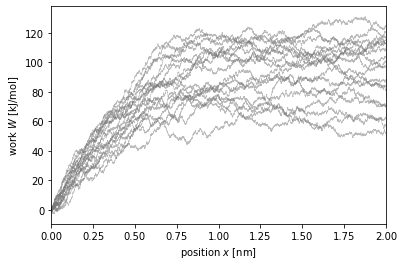

In [6]:
# plot workset
import matplotlib.pyplot as plt
from dcTMD.utils import plotting

fig, ax = plt.subplots()
plotting.plot_worklines(forceset.position_, forceset.work_, ax)
plt.show()

shapiro wilkins results at x=0.5 is ShapiroResult(statistic=0.9809889793395996, pvalue=0.9596364498138428)
Kolmogorov-Smirnov results at x=0.5 is KstestResult(statistic=1.0, pvalue=0.0)
shapiro wilkins results at x=1.5 is ShapiroResult(statistic=0.9350144863128662, pvalue=0.23768189549446106)
Kolmogorov-Smirnov results at x=1.5 is KstestResult(statistic=1.0, pvalue=0.0)


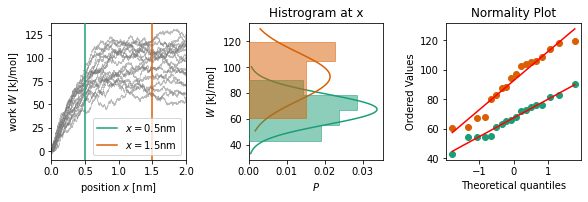

In [7]:
# check if work distribution follows a normal distribution
from scipy.stats import kstest, shapiro
from dcTMD.utils import plotting

index = [5000, 15000]
x = forceset.position_

fig, axs = plotting.plot_worknormalitychecks(x, forceset.work_, index)

for i, p in enumerate(index):
    # Shapiro-Wilk Test
    shapiro_test = shapiro(forceset.work_[:,p])
    print(f'shapiro wilkins results at x={x[p]} is {shapiro_test}')
    # Kolmogorov-Smirnov Test
    kstest_test = kstest(forceset.work_[:,p], 'norm')
    print(f'Kolmogorov-Smirnov results at x={x[p]} is {kstest_test}')

### III. derive estimates from forceset

1. create ForceEstimator instance
2. fit ForceEstimator instance with previously created forceset

In [8]:
## load force
# force = load('my_force_set')
# Instantiate a ForceEstimator instance and fit it with the ForceSet
# instance
forceestimator = ForceEstimator(temperature)
forceestimator.fit(forceset)
vars(forceestimator)

Calculating dissipative work...


{'temperature': 290,
 'verbose': False,
 'force_set': ForceSet(velocity=0.001),
 'names_': array(['t_middle_32_pullf.xvg', 't_middle_03_pullf.xvg',
        't_middle_34_pullf.xvg', 't_middle_24_pullf.xvg',
        't_middle_21_pullf.xvg', 't_middle_04_pullf.xvg',
        't_middle_29_pullf.xvg', 't_middle_16_pullf.xvg',
        't_middle_30_pullf.xvg', 't_middle_19_pullf.xvg',
        't_middle_01_pullf.xvg', 't_middle_28_pullf.xvg',
        't_middle_26_pullf.xvg', 't_middle_31_pullf.xvg',
        't_middle_09_pullf.xvg', 't_middle_17_pullf.xvg',
        't_middle_25_pullf.xvg', 't_middle_05_pullf.xvg'], dtype='<U32'),
 'delta_force_array': array([[-8.73736883e+02,  2.06404027e+03, -1.64675083e+03, ...,
         -3.84514611e+02, -6.60017244e+02,  1.03823811e+03],
        [-1.21761218e+03, -1.68094973e+03, -5.91505833e+02, ...,
         -1.45385561e+03,  6.41780156e+02, -6.25663889e+02],
        [-2.50703183e+02,  6.28820267e+02, -7.42814833e+02, ...,
          1.87819439e+03,  6.96557

#### Visualize results
In the package a couple of simple plot functions to get an overview of the results are implemented. e.g. plot_dcTMD_results()

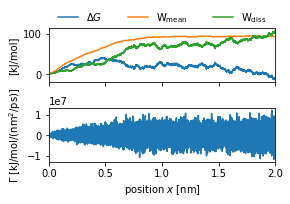

In [9]:
# plot dcTMD results
from dcTMD.utils import plotting

fig, axs = plotting.plot_dcTMD_results(forceestimator.position_,
                                      forceestimator,
                                      forceestimator.friction_)

plt.show()

#### Smooth friction estimate
Finally, the friction estimate needs to be smoothed.
This can be done via 
dcTMD.utils.smoothing.gaussfilter_friction() or 
dcTMD.WorkEstimator.smooth_friction(sigma, mode)
sigma is the standard deviation of gaussian kernel in nm
the mode parameter determines how the input array is extended beyond its boundaries.

*Caution:* this can lead to long computations using large datasets and a big smoothing window.

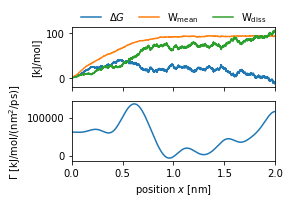

In [10]:
# smooth friction and plot results
forceestimator.smooth_friction(sigma=0.1, mode='reflect')


fig, axs = plotting.plot_dcTMD_results(forceestimator.position_,
                                      forceestimator,
                                      forceestimator.friction_smooth_)
plt.show()

### IV. Save and load results


In [16]:
# save data as .npz and .dat file
outname = 'test'
dcTMD.io.write_output(outname, forceestimator)

results = np.load(f'test_N{len(forceestimator.names_)}_dG.npz')

results.files

save file test_N18_dG.dat
dave file test_N18_dG.npz


['x', 'Wmean', 'Wdiss', 'dG', 'Gamma']